In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import dill
import numpy as np
import pandas as pd
import scipy.io as io
import datetime
import h5py
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

sys.path.append('../../efish-physics-model/helper_functions')
sys.path.append('../../efish-physics-model/objects')
sys.path.append('../../efish-physics-model/uniform_points_generation')

In [3]:
from FishGeneration import FishGeneration
from Fish_IceCreamCone import IceCreamConeFish
from Fish_Capsule import CapsuleFish

from assertion_tests import run_tests
run_tests()

'Success!'

# Scale the base to exaperimental measurements

In [4]:
def provide_data_like_base(
    receptor_x_positions,
    polyfit_id_ends=[28, 59],
    chin_value=0.125,
    adjustments=dict(ids=[23, 24, 25, 26, 27], vals=[0.2, 0.35, 0.25, 0.22, 0.2]),
):
    base_amplitude_data_like = np.polyfit(
        [-receptor_x_positions[polyfit_id_ends[0]] * 1e2, -receptor_x_positions[polyfit_id_ends[1]] * 1e2],
        [0.2, 0.5],
        1,
    )
    base_amplitude_data_like = np.array(
        [chin_value] * np.sum(receptor_x_positions >= 0)
        + list(
            base_amplitude_data_like[0] * (-receptor_x_positions[receptor_x_positions < 0] * 1e2)
            + base_amplitude_data_like[1]
        )
    )
    for i in range(len(adjustments["ids"])):
        base_amplitude_data_like[adjustments["ids"][i]] = adjustments["vals"][i]
    return base_amplitude_data_like

In [5]:
dataset_area = "head"
dataset = dill.load(
    open(
        f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/dataset.pkl",
        "rb",
    )
)
base_responses = dataset["electric_images"]["base"]["responses"][0].reshape(25 * 3, 16, 2)
receptors_locations = dataset["fish"]["dataframe"]["objs"].iloc[0].get_receptors_locations().reshape(25 * 3, 16, 3)

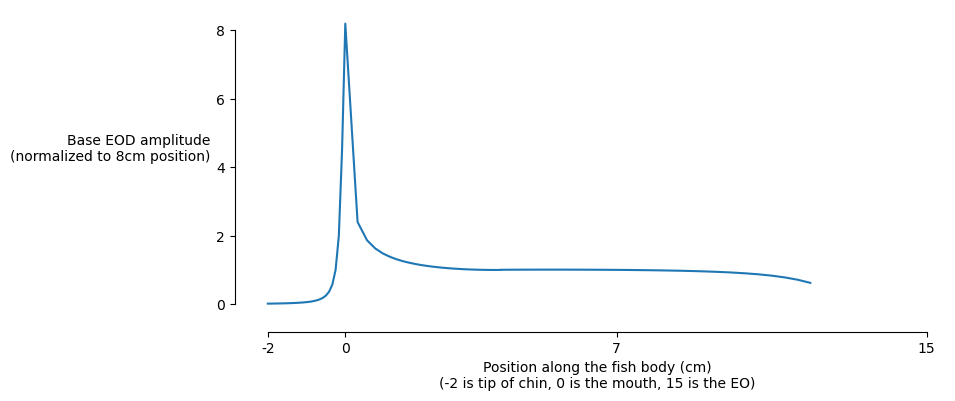

normalized at x position: 70 mm -> respective normalization value: 9155


In [6]:
normalized_id = 59
base_amplitude_avg = base_responses[:, :, 0].mean(1)
receptor_x_positions = receptors_locations[:, 0, 0]
plt.figure(figsize=(9, 4))
plt.plot(-receptor_x_positions * 1e2, base_amplitude_avg / base_amplitude_avg[normalized_id])
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks([-2, 0, round(-receptor_x_positions[normalized_id]*1e2), 15], [-2, 0, round(-receptor_x_positions[normalized_id]*1e2), 15])
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.show()
print(f"normalized at x position: {-receptor_x_positions[normalized_id]*1e3:.0f} mm -> respective normalization value: {base_amplitude_avg[normalized_id]:.0f}")

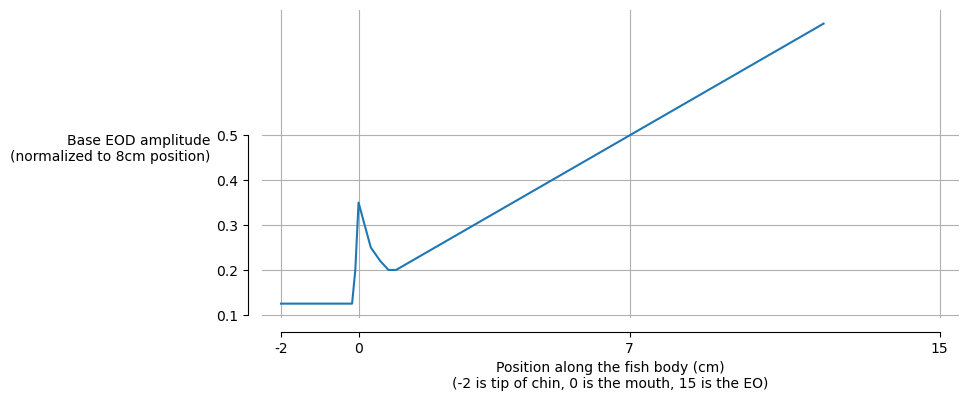

In [7]:
base_amplitude_data_like = provide_data_like_base(receptor_x_positions)
plt.figure(figsize=(9, 4))
plt.plot(-receptor_x_positions * 1e2, base_amplitude_data_like)
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks((np.arange(5) + 1) / 10)
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
# plt.yscale("log")
sns.despine(offset=10, trim=True)
plt.grid()
plt.show()

In [8]:
def scale_base_to_data_like(base_responses=base_responses, base_amplitude_data_like=base_amplitude_data_like, normalized_id=59):
    new_base_responses = (
        base_responses
        / base_responses[:, :, 0].mean(1)[:, np.newaxis, np.newaxis]
        * base_amplitude_data_like[:, np.newaxis, np.newaxis]
    )
    new_base_responses = new_base_responses / new_base_responses[normalized_id] * base_responses[normalized_id]
    return new_base_responses

In [9]:
new_base_responses = scale_base_to_data_like()

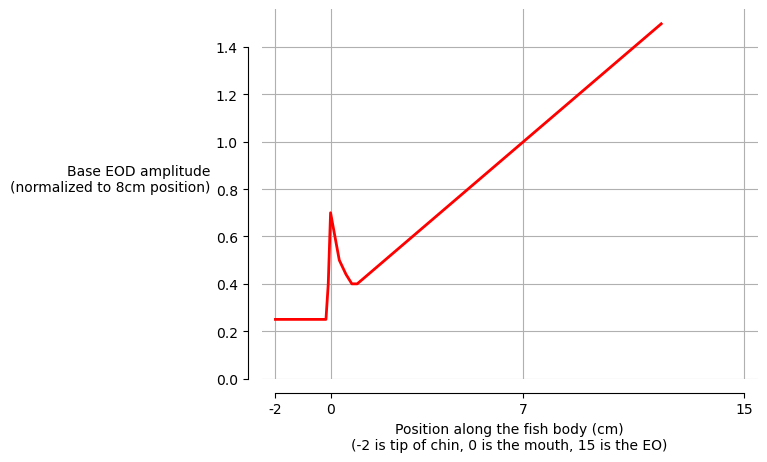

In [36]:
plt.plot(-receptor_x_positions*1e2, new_base_responses[:,:,0].mean(1) / new_base_responses[:,:,0].mean(1)[normalized_id], lw=2, c="r")
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks(np.arange(8) / 5)
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.grid()
plt.show()

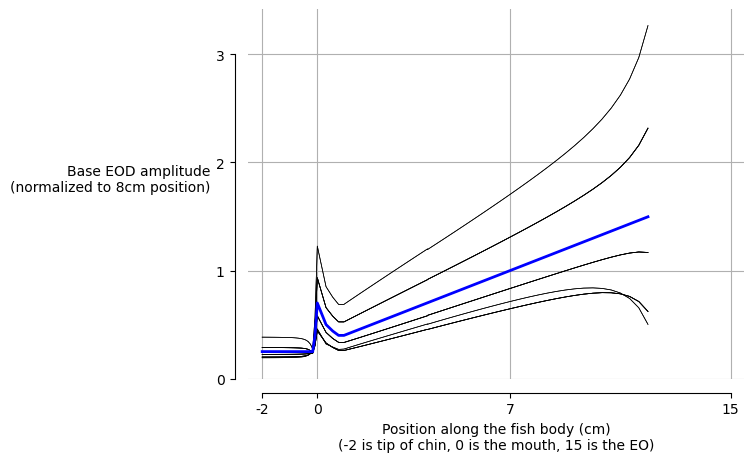

In [33]:
plt.plot(-receptor_x_positions*1e2, new_base_responses[:, :, 0] / new_base_responses[:,:,0].mean(1)[normalized_id], lw=0.5, c="k")
plt.plot(-receptor_x_positions*1e2, new_base_responses[:,:,0].mean(1) / new_base_responses[:,:,0].mean(1)[normalized_id], lw=2, c="b")
plt.xlabel("Position along the fish body (cm)\n(-2 is tip of chin, 0 is the mouth, 15 is the EO)")
plt.xticks(
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
    [-2, 0, round(-receptor_x_positions[normalized_id] * 1e2), 15],
)
plt.yticks(np.arange(4))
plt.xlim(-2.5, 15.5)
plt.ylabel("Base EOD amplitude\n(normalized to 8cm position)", rotation=0, ha="right")
sns.despine(offset=10, trim=True)
plt.grid()
plt.show()

# Detection with chin

In [12]:
dataset_areas = ["chin", "head", "body"]
dataset_area_receptor_y = dict(zip(dataset_areas, [1e-3, 7.5e-3, 9e-3]))
objects = []
modulations = []
for i, dataset_area in enumerate(dataset_areas):
    dataset = dill.load(
        open(
            f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/dataset.pkl",
            "rb",
        )
    )
    responses = h5py.File(
        f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/responses.hdf5",
        "r",
    )["responses"][:]
    base_responses = dataset["electric_images"]["base"]["responses"][0]
    temp_modulations = responses / base_responses - 1

    temp_objects = dataset["worms"]["dataframe"].copy()
    for col in temp_objects:
        temp_objects[col] = temp_objects[col].apply(lambda x: dataset["worms"][col][x])
    temp_objects["position_ys"] = (
        temp_objects["position_ys"] - dataset["worms"]["radii"][0] - dataset_area_receptor_y[dataset_area]
    ) * 1e3

    objects.append(temp_objects)
    modulations.append(temp_modulations)
objects = pd.concat(objects)
modulations = np.concatenate(modulations).reshape(-1, 25 * 3, 16, 2)
base_responses = dataset["electric_images"]["base"]["responses"][0].reshape(25 * 3, 16, 2)
receptors_locations = dataset["fish"]["dataframe"]["objs"].iloc[0].get_receptors_locations().reshape(25 * 3, 16, 3)

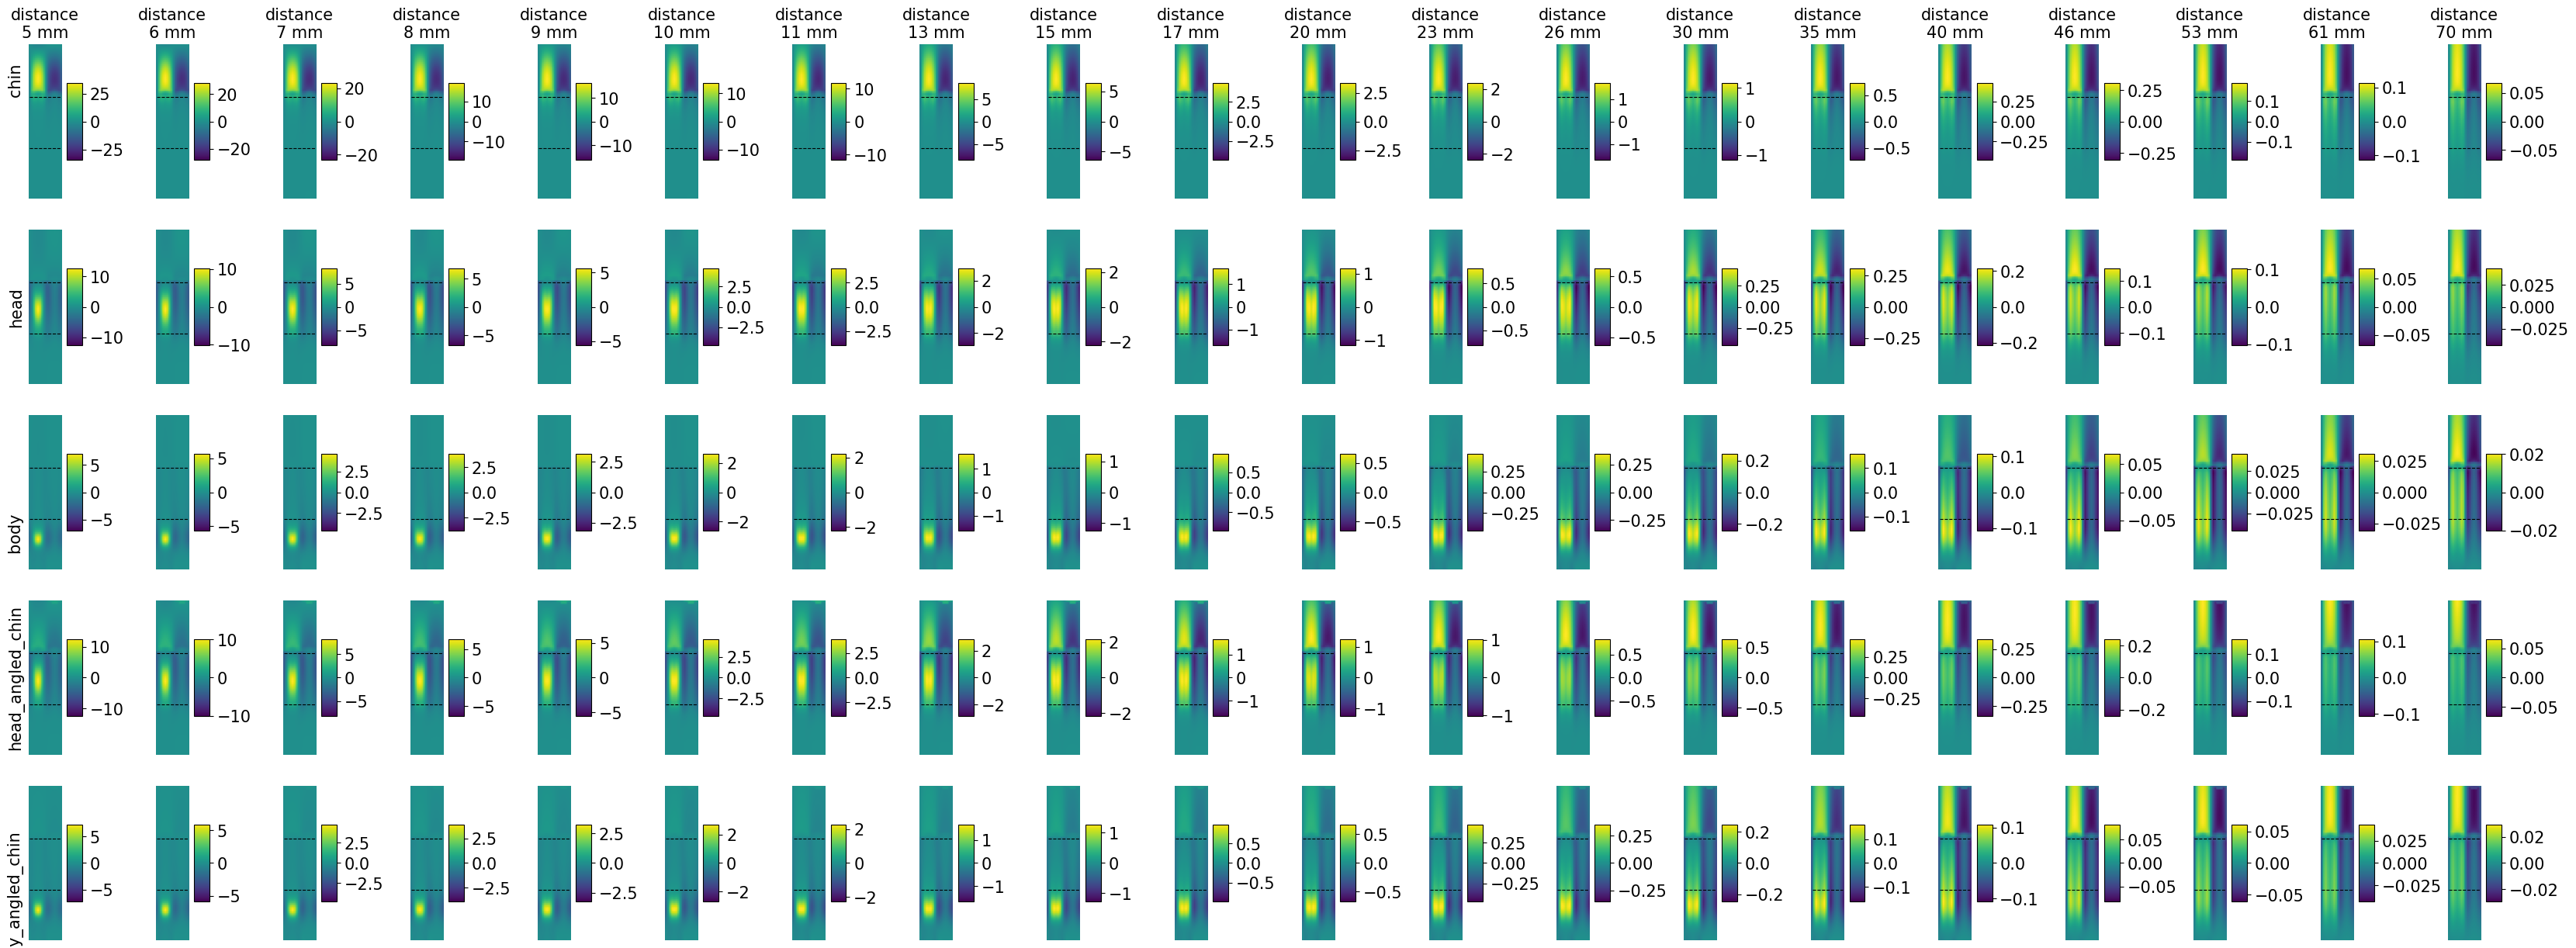

In [14]:
zone = "mz"
dataset_areas = ["chin", "head", "body", "head_angled_chin", "body_angled_chin"]
object_ids = np.arange(20)

zones = dict(mz=0, dlz=1)
f, axes = plt.subplots(len(dataset_areas), 20, figsize=(42, 3 * len(dataset_areas)))  # , gridspec_kw = {'wspace':0.09, 'hspace':-0.95})
for i, dataset_area in enumerate(dataset_areas):
    fpath = f"../../efish-physics-model/data/processed/data-2024_06_06-fish_with_chin_for_detection-{dataset_area}/"
    if "_" in dataset_area:
        fpath = f"../../efish-physics-model/data/processed/data-2024_06_14-fish_with_angled_chin_for_detection-{dataset_area}/"

    dataset = dill.load(
        open(
            f"{fpath}dataset.pkl",
            "rb",
        )
    )
    responses = h5py.File(
        f"{fpath}responses.hdf5",
        "r",
    )[
        "responses"
    ][:]
    base_response = dataset["electric_images"]["base"]["responses"][0]

    for j, object_id in enumerate(object_ids):
        selected_response = (
            (responses[object_id, :, zones[zone]] - base_response[:, zones[zone]]).reshape(25 * 3, 16)
            / new_base_responses[:, :, zones[zone]]
            * 100
        )
        vval = np.max(np.abs(selected_response))
        # selected_response = selected_response + np.random.randn(*selected_response.shape) * 1
        cbar = axes[i, j].imshow(selected_response, vmin=-vval, vmax=vval)
        sns.despine(left=True, bottom=True)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].plot([0, 15], [25, 25], "k--", lw=0.8)
        axes[i, j].plot([0, 15], [50, 50], "k--", lw=0.8)
        cbar = plt.colorbar(cbar, shrink=0.5, aspect=5)
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(15)
        if j == 0:
            ylabel = dataset_area
            if dataset_area == "chin":
                ylabel = "                " + dataset_area
            if "body" in dataset_area:
                ylabel = dataset_area + "                "
            axes[i, j].set_ylabel(ylabel, fontsize=15)
        if i == 0:
            temp_distance = dataset["worms"]["position_ys"][object_id] * 1e3 - dataset["worms"]["radii"][0] * 1e3 - 1
            axes[i, j].set_title(f"distance\n{temp_distance:.0f} mm", fontsize=15)
plt.show()